In [ ]:
#link với google driver
from google.colab import drive
drive.mount('/content/driver')


Mounted at /content/driver


In [ ]:
#import các thư viện
import numpy as np 
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

Load data

In [ ]:
dataframe = pd.read_csv('/content/driver/My Drive/Deep-Learning/stock5/weather.csv')
dataframe

,time,month,temperature,feelslike,wind,direction,gust,cloud,humidity,precipitation,pressure,weather
0,0:00,1,23,25,7,NE,11,21,68,0.0,1010,Clear
1,3:00,1,22,25,6,NNE,8,22,71,0.0,1010,Clear
2,6:00,1,22,25,8,ENE,9,16,72,0.0,1011,Sunny
3,9:00,1,27,30,8,E,9,14,55,0.0,1011,Sunny
4,12:00,1,32,34,4,ENE,5,46,41,0.0,1009,Partly cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...
2915,9:00,12,28,30,16,NNE,18,8,59,0.0,1013,Sunny
2916,12:00,12,32,36,13,NNE,15,15,49,0.0,1012,Sunny
2917,15:00,12,32,36,10,NNE,13,26,53,0.0,1010,Partly cloudy
2918,18:00,12,27,28,15,N,26,71,55,0.0,1013,Cloudy


In [ ]:
#import dataset
#chuyển data về dạng numpy
data = np.array(dataframe.values)
data_end = int(np.floor(0.8*(dataframe.shape[0])))
train = dataframe[0:data_end]['temperature']
train =train.values.reshape(-1)
test = dataframe[data_end:]['temperature'].values.reshape(-1)
date_test = dataframe[data_end:]['time'].values.reshape(-1)

In [ ]:
# chia dữ liệu X ; X các cột đầu
x = data[:,0:-1]
print(x.shape)
print(x[:5])

(2920, 11)
[['0:00' 1 23 25 7 'NE' 11 21 68 0.0 1010]
 ['3:00' 1 22 25 6 'NNE' 8 22 71 0.0 1010]
 ['6:00' 1 22 25 8 'ENE' 9 16 72 0.0 1011]
 ['9:00' 1 27 30 8 'E' 9 14 55 0.0 1011]
 ['12:00' 1 32 34 4 'ENE' 5 46 41 0.0 1009]]


In [ ]:
# chia dữ liệu y ; y là cột cuối
y = data[:,-1]
y.ravel()
print(y.shape)
print(y[:10])

(2920,)
['Clear' 'Clear' 'Sunny' 'Sunny' 'Partly cloudy' 'Sunny' 'Clear' 'Clear'
 'Clear' 'Clear']


In [ ]:
#đếm các giá trị trong y
from collections import Counter
counter = Counter()
counter.update(y)
print(counter)

Counter({'Partly cloudy': 1096, 'Clear': 581, 'Sunny': 532, 'Cloudy': 184, 'Moderate or heavy rain shower': 122, 'Patchy rain possible': 119, 'Light rain shower': 115, 'Overcast': 71, 'Thundery outbreaks possible': 31, 'Torrential rain shower': 19, 'Patchy light rain with thunder': 11, 'Patchy light rain': 8, 'Light rain': 7, 'Patchy light drizzle': 6, 'Light drizzle': 5, 'Moderate rain': 4, 'Mist': 3, 'Heavy rain': 3, 'Moderate rain at times': 2, 'Heavy rain at times': 1})


In [ ]:
#chuẩn hóa dữ liệu
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(y)

[ 0  0 17 ... 12  1  6]


In [ ]:
#xử lý dữ liệu
def get_data(train,test,time_step,num_predict,date):
  x_train= list()
  y_train = list()
  x_test = list()
  y_test = list()
  date_test= list()

  for i in range(0,len(train) - time_step - num_predict):
    x_train.append(train[i:i+time_step])
    y_train.append(train[i+time_step:i+time_step+num_predict])

  for i in range(0, len(test) - time_step - num_predict):
    x_test.append(test[i:i+time_step])
    y_test.append(test[i+time_step:i+time_step+num_predict])
    date_test.append(date[i+time_step:i+time_step+num_predict])
  
  return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test), np.asarray(date_test)

In [ ]:
#chia bộ dữ liệu train, test
x_train, y_train, x_test, y_test, date_test = get_data(train,test,30,1, date_test)

# đưa về 0->1 cho tập train
scaler = MinMaxScaler()
x_train = x_train.reshape(-1,30)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

# đưa về 0->1 cho tập test
x_test = x_test.reshape(-1,30)

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)

In [ ]:
print(x_train[:2])
print(x_train.shape[0])
print(x_train.shape[1])

[[0.16666667 0.11111111 0.11111111 0.38888889 0.66666667 0.61111111
  0.33333333 0.22222222 0.16666667 0.11111111 0.11111111 0.44444444
  0.66666667 0.61111111 0.33333333 0.27777778 0.22222222 0.16666667
  0.16666667 0.5        0.72222222 0.66666667 0.38888889 0.27777778
  0.27777778 0.22222222 0.22222222 0.5        0.72222222 0.72222222]
 [0.11111111 0.11111111 0.38888889 0.66666667 0.61111111 0.33333333
  0.22222222 0.16666667 0.11111111 0.11111111 0.44444444 0.66666667
  0.61111111 0.33333333 0.27777778 0.22222222 0.16666667 0.16666667
  0.5        0.72222222 0.66666667 0.38888889 0.27777778 0.27777778
  0.22222222 0.22222222 0.5        0.72222222 0.72222222 0.44444444]]
2305
30


In [ ]:
print(x_train.shape[1])

30


In [ ]:
#embed_dim = 128
hidden_size = 200
batch_size = 32

timesteps = x_train.shape[1]
x_dim = 1

model = models.Sequential()
model.add(layers.SimpleRNN(hidden_size,input_shape=(timesteps,x_dim)))
model.add(layers.Dense(128,activation='sigmoid'))
model.add(layers.Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 200)               40400     
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 66,515
Trainable params: 66,515
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Reshape lại cho đúng model
x_train = x_train.reshape(-1,30,1)
y_train = y_train.reshape(-1,1)


In [ ]:
#reshape lại cho test
x_test = x_test.reshape(-1,30,1)
y_test = y_test.reshape(-1,1)
date_test = date_test.reshape(-1,1)

In [ ]:
# chỉnh lại đầu vào 
print(x_train.shape)
n_examples = x_train.shape[0]
time_steps = x_train.shape[1] 
X_train_transformed = x_train.reshape(n_examples,time_steps,1)
print(X_train_transformed.shape)

(2305, 30, 1)
(2305, 30, 1)


In [ ]:
# xây dựng mô hình mạng
# đầu vào 30 đoạn 1
n_input = 30
n_features = 1

model = Sequential()
model.add(LSTM(units=50,activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(1))

In [ ]:
#tối ưu hóa thuật toán
model.compile(optimizer='adam', loss='mse')

In [ ]:
#huấn luyện mạng
model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=1, batch_size=30)
model.save('/content/driver/My Drive/Deep-Learning/stock5/30_to_1.h5')

Epoch 1/100
62/62 [==============================] - 10s 72ms/step - loss: 0.0483 - val_loss: 0.0207
Epoch 2/100
62/62 [==============================] - 4s 58ms/step - loss: 0.0338 - val_loss: 0.0229
Epoch 3/100
62/62 [==============================] - 3s 54ms/step - loss: 0.0316 - val_loss: 0.0203
Epoch 4/100
62/62 [==============================] - 4s 57ms/step - loss: 0.0318 - val_loss: 0.0207
Epoch 5/100
62/62 [==============================] - 3s 53ms/step - loss: 0.0319 - val_loss: 0.0203
Epoch 6/100
62/62 [==============================] - 3s 56ms/step - loss: 0.0315 - val_loss: 0.0208
Epoch 7/100
62/62 [==============================] - 3s 52ms/step - loss: 0.0296 - val_loss: 0.0196
Epoch 8/100
62/62 [==============================] - 4s 60ms/step - loss: 0.0281 - val_loss: 0.0198
Epoch 9/100
62/62 [==============================] - 3s 53ms/step - loss: 0.0278 - val_loss: 0.0164
Epoch 10/100
62/62 [==============================] - 3s 52ms/step - loss: 0.0216 - val_loss: 0.009

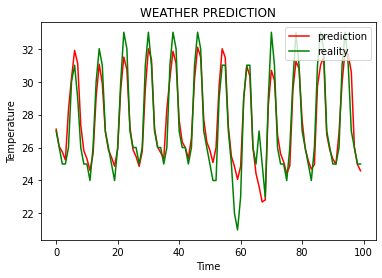

In [ ]:
#chạy kết quả test
model = keras.models.load_model('/content/driver/My Drive/Deep-Learning/stock5/30_to_1.h5')

test_output = model.predict(x_test)

# print(test_output)
test_1 = scaler.inverse_transform(test_output)
test_2=scaler.inverse_transform(y_test)
plt.plot(test_1[:100], color='r')
plt.plot(test_2[:100] ,color='g')
plt.title("WEATHER PREDICTION")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()